In [ ]:
import pandas as pd
import torch
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
from transformers import (
    BertTokenizer,
    BertForSequenceClassification,
    Trainer,
    TrainingArguments,
    EarlyStoppingCallback
)
from torch.utils.data import Dataset
import os
import random
import warnings

# Setup agar warning tidak mengganggu
warnings.filterwarnings('ignore')

# Konfigurasi Utama
CONFIG = {
    'model_name': "indobenchmark/indobert-base-p1",
    'max_len': 128,
    'batch_size': 16,     # Ubah ke 8 jika VRAM kecil
    'epochs': 5,          # Maksimal epoch
    'learning_rate': 2e-5,
    'seed': 42
}

# Fungsi untuk mengunci seed (agar hasil konsisten)
def set_seed(seed):
    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    if torch.cuda.is_available():
        torch.cuda.manual_seed_all(seed)

set_seed(CONFIG['seed'])

# Cek Device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"🚀 Device: {device}")

🚀 Device: cuda


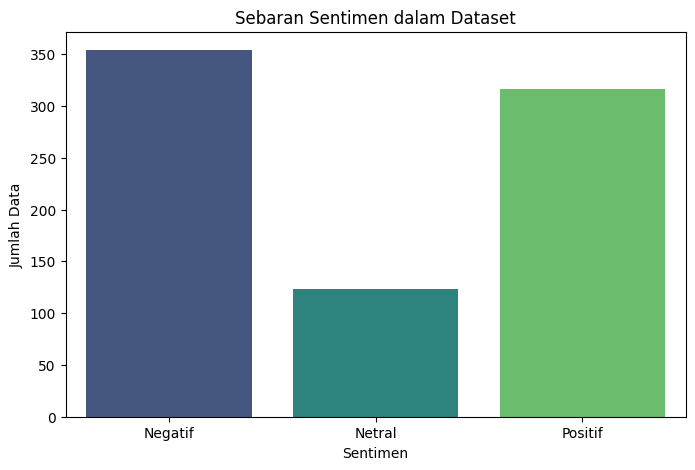

Total Data: 793


In [ ]:
# Load Dataset
filename = 'dataset_sentimen - Sheet2 (1).csv' # Pastikan nama file sesuai
df = pd.read_csv(filename)

# Bersihkan Data
df = df.dropna(subset=['processed_text', 'label'])

# Mapping Label
label_map = {'Negatif': 0, 'Netral': 1, 'Positif': 2}
df['label_encoded'] = df['label'].map(label_map)

# Visualisasi Sebaran Data
plt.figure(figsize=(8, 5))
sns.countplot(x='label', data=df, palette='viridis', order=['Negatif', 'Netral', 'Positif'])
plt.title('Sebaran Sentimen dalam Dataset')
plt.xlabel('Sentimen')
plt.ylabel('Jumlah Data')
plt.show()

print(f"Total Data: {len(df)}")

In [ ]:
# Split Data (80% Train, 20% Val)
train_texts, val_texts, train_labels, val_labels = train_test_split(
    df['processed_text'].tolist(),
    df['label_encoded'].tolist(),
    test_size=0.2,
    random_state=CONFIG['seed'],
    stratify=df['label_encoded']
)

# Class Dataset untuk IndoBERT
class SentimentDataset(Dataset):
    def __init__(self, texts, labels, tokenizer, max_len):
        self.texts = texts
        self.labels = labels
        self.tokenizer = tokenizer
        self.max_len = max_len

    def __len__(self):
        return len(self.texts)

    def __getitem__(self, item):
        text = str(self.texts[item])
        label = self.labels[item]

        encoding = self.tokenizer.encode_plus(
            text,
            add_special_tokens=True,
            max_length=self.max_len,
            padding='max_length',
            truncation=True,
            return_attention_mask=True,
            return_tensors='pt',
        )

        return {
            'input_ids': encoding['input_ids'].flatten(),
            'attention_mask': encoding['attention_mask'].flatten(),
            'labels': torch.tensor(label, dtype=torch.long)
        }

# Load Tokenizer
tokenizer = BertTokenizer.from_pretrained(CONFIG['model_name'])

# Buat Objek Dataset
train_dataset = SentimentDataset(train_texts, train_labels, tokenizer, CONFIG['max_len'])
val_dataset = SentimentDataset(val_texts, val_labels, tokenizer, CONFIG['max_len'])

tokenizer_config.json:   0%|          | 0.00/2.00 [00:00<?, ?B/s]

vocab.txt: 0.00B [00:00, ?B/s]

special_tokens_map.json:   0%|          | 0.00/112 [00:00<?, ?B/s]

config.json: 0.00B [00:00, ?B/s]

In [ ]:
# Load Model
model = BertForSequenceClassification.from_pretrained(CONFIG['model_name'], num_labels=3)
model.to(device)

# Fungsi Metrik
def compute_metrics(pred):
    labels = pred.label_ids
    preds = pred.predictions.argmax(-1)
    acc = accuracy_score(labels, preds)
    return {'accuracy': acc}

# Training Arguments
training_args = TrainingArguments(
    output_dir='./results',
    num_train_epochs=CONFIG['epochs'],
    per_device_train_batch_size=CONFIG['batch_size'],
    per_device_eval_batch_size=32,
    learning_rate=CONFIG['learning_rate'],
    warmup_steps=100,
    weight_decay=0.01,
    logging_dir='./logs',
    logging_steps=10,             # Log setiap 10 steps agar grafiknya mulus
    eval_strategy="epoch",  # Evaluasi tiap epoch
    save_strategy="epoch",        # Simpan tiap epoch
    load_best_model_at_end=True,  # Ambil model terbaik di akhir
    metric_for_best_model="accuracy",
    report_to="none"
)

# Trainer
trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=train_dataset,
    eval_dataset=val_dataset,
    compute_metrics=compute_metrics,
    callbacks=[EarlyStoppingCallback(early_stopping_patience=2)] # Berhenti jika tidak ada progress
)

# Mulai Training
print("🏋️ Mulai Training...")
trainer.train()

pytorch_model.bin:   0%|          | 0.00/498M [00:00<?, ?B/s]

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


🏋️ Mulai Training...


model.safetensors:   0%|          | 0.00/498M [00:00<?, ?B/s]

Epoch,Training Loss,Validation Loss,Accuracy
1,0.834300,0.658770,0.748428
2,0.466700,0.478007,0.792453
3,0.376200,0.373768,0.861635
4,0.161300,0.461258,0.849057
5,0.016200,0.417351,0.880503


TrainOutput(global_step=200, training_loss=0.4028121031820774, metrics={'train_runtime': 134.0736, 'train_samples_per_second': 23.644, 'train_steps_per_second': 1.492, 'total_flos': 208517383549440.0, 'train_loss': 0.4028121031820774, 'epoch': 5.0})

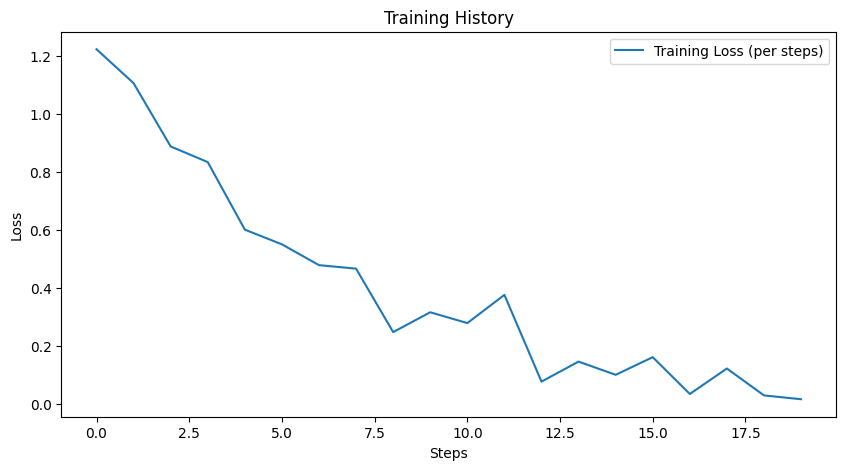

Evaluasi Terakhir: 88.05%


In [ ]:
# Mengambil history dari trainer
history = trainer.state.log_history
train_loss = [x['loss'] for x in history if 'loss' in x]
eval_loss = [x['eval_loss'] for x in history if 'eval_loss' in x]
epochs = range(1, len(eval_loss) + 1)

# Plot Loss
plt.figure(figsize=(10, 5))
# Karena log steps berbeda untuk train dan eval, kita plot terpisah atau gunakan eval points
if len(train_loss) > 0:
    plt.plot(train_loss, label='Training Loss (per steps)')

# Plot Eval Loss (per epoch)
plt.title('Training History')
plt.xlabel('Steps')
plt.ylabel('Loss')
plt.legend()
plt.show()

print(f"Evaluasi Terakhir: {trainer.evaluate()['eval_accuracy']:.2%}")


📝 Classification Report:

              precision    recall  f1-score   support

     Negatif       0.86      0.93      0.89        71
      Netral       0.75      0.72      0.73        25
     Positif       0.97      0.89      0.93        63

    accuracy                           0.88       159
   macro avg       0.86      0.85      0.85       159
weighted avg       0.88      0.88      0.88       159



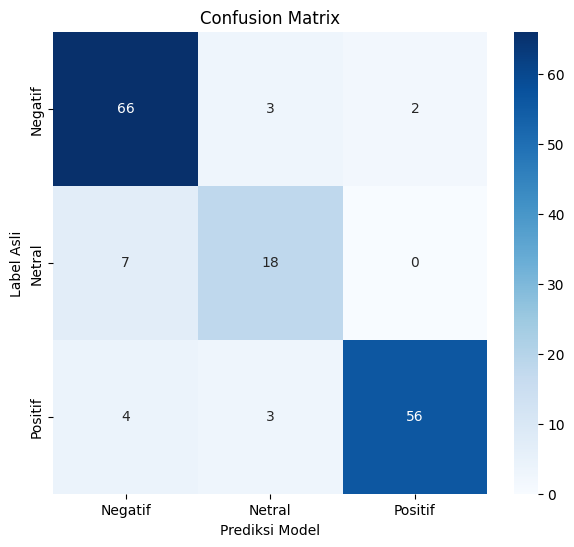

In [ ]:
# Prediksi data validasi
predictions = trainer.predict(val_dataset)
preds = np.argmax(predictions.predictions, axis=1)
labels = predictions.label_ids

# Classification Report
print("\n📝 Classification Report:\n")
print(classification_report(labels, preds, target_names=['Negatif', 'Netral', 'Positif']))

# Confusion Matrix Heatmap
cm = confusion_matrix(labels, preds)
plt.figure(figsize=(7, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=['Negatif', 'Netral', 'Positif'],
            yticklabels=['Negatif', 'Netral', 'Positif'])
plt.title('Confusion Matrix')
plt.xlabel('Prediksi Model')
plt.ylabel('Label Asli')
plt.show()

In [ ]:
def predict_text(text):
    inputs = tokenizer(text, return_tensors="pt", truncation=True, padding=True, max_length=128).to(device)
    with torch.no_grad():
        logits = model(**inputs).logits

    probs = torch.nn.functional.softmax(logits, dim=-1)
    pred_idx = torch.argmax(probs, dim=1).item()

    label_map_inv = {0: 'Negatif', 1: 'Netral', 2: 'Positif'}
    return label_map_inv[pred_idx], probs[0][pred_idx].item()

# Contoh Test
texts = [
    "Program ini sangat membantu rakyat kecil",
    "Jujur kecewa banget sama pelayanannya",
    "Biasa aja sih"
]

print("\n🧪 Hasil Prediksi:")
for t in texts:
    lbl, conf = predict_text(t)
    print(f"Text: {t}\n -> {lbl} ({conf:.2%})\n")


🧪 Hasil Prediksi:
Text: Program ini sangat membantu rakyat kecil
 -> Positif (99.65%)

Text: Jujur kecewa banget sama pelayanannya
 -> Negatif (99.09%)

Text: Biasa aja sih
 -> Netral (65.61%)

